# Import libraries, read image

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob
# from operator import itemgetter

In [2]:
# read BGR image
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html
#_img = cv2.imread('blender_capture.png')
#_img = cv2.imread('./images/catadioptric_f-6-mm_3.jpg')
#_img = cv2.imread('monkey_head_v2.png')
_img = cv2.imread('chessboard.png')
height, width, channels = _img.shape
print("img.shape = " + str(_img.shape))

img.shape = (540, 960, 3)


# Select the image border manually

In [3]:
params = {'BORDER_OFFSET':-1}

In [4]:
def select_border(event, x, y, flags, params):
    if (event == cv2.EVENT_LBUTTONUP) and (params['BORDER_OFFSET'] == -1):
        params['BORDER_OFFSET'] = x

In [5]:
cv2.namedWindow('select border', cv2.WINDOW_NORMAL)
cv2.setMouseCallback('select border', select_border, params)
cv2.setWindowProperty('select border', cv2.WINDOW_FULLSCREEN, 1)
cv2.imshow('select border', _img)

while(1): # wait for selection or ESC key    
    if params['BORDER_OFFSET'] >= 0: 
        break
    if cv2.waitKey(20) & 0xFF == 27: 
        break
cv2.destroyAllWindows()

# Optical Flow

In [28]:
cap = cv2.VideoCapture('/Users/dominikbornand/Desktop/ETHZ/FS21/3D_Vision/Catadioptric-Stereo/animation/movie_small.avi') 
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
#https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 10,
                       qualityLevel = 0.1,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 4,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))


# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
print(type(p0))
#p0 = np.array([[[50.,382.]],[[100.,382.]],[[150.,382.]],[[200.,382.]],[[250.,382.]],[[300.,382.]],[[350.,382.]],[[400.,382.]],
#              [[450.,382.]],[[500.,382.]],[[550.,382.]],[[600.,382.]],[[650.,382.]],[[700.,382.]],[[750.,382.]]])
p0= np.array([[50.,382.],[100.,382.]])
print(type(p0))
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(1):
    ret, frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]
        
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new, good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), color[i].tolist(), 2)
        frame = cv2.circle(frame,(int(a),int(b)),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)
    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
        
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yvyj7qlp/opencv/modules/video/src/lkpyramid.cpp:1257: error: (-215:Assertion failed) (npoints = prevPtsMat.checkVector(2, CV_32F, true)) >= 0 in function 'calc'


In [ ]:
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            cv2.imshow("Output", gray)
    else:
        break
    key = cv2.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()




# Split into left and right image

In [6]:
print('Offset = ' + str(params['BORDER_OFFSET']))
x = params['BORDER_OFFSET']

# draw black line at x
_img[:,x,:] = 0
img = _img

# flip right image horizontally
img[:,x+1:,:] = cv2.flip(img[:,x+1:,:], 1) 

# determine width of stereo images 
new_width = x # min(x, width-x) 

# draw line of right image with new width 
img[:,x+1+new_width, :] = 0

# crop images and make grayscale
# why it's necessary to crop the image ??
imgR = cv2.cvtColor(img[:,:x,:], cv2.COLOR_BGR2GRAY)
imgL = cv2.cvtColor(img[:,x+1:x+1+new_width,:], cv2.COLOR_BGR2GRAY)

cv2.imshow('select border', img)
#cv2.imshow('imgL', imgL)
#cv2.imshow('imgR', imgR)
cv2.waitKey(0)
cv2.destroyAllWindows()

Offset = 413


# Chessboard

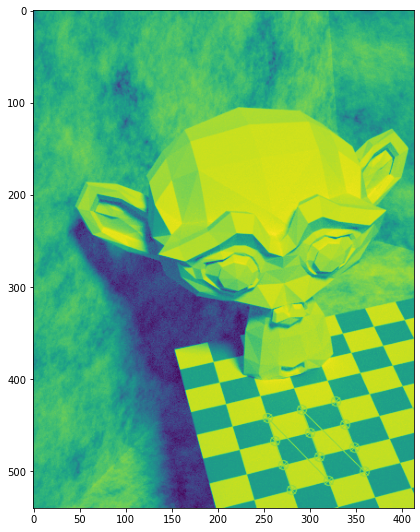

In [7]:
# termination criteria
#criteria = (cv2.audioa.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((3*4,3), np.float32)
objp[:,:2] = np.mgrid[0:4,0:3].T.reshape(-1,2)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TermCriteria_COUNT, 40, 0.001)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
# Find the chess board corners
ret, corners = cv2.findChessboardCorners(imgL, (4,3), None)
# If found, add object points, image points (after refining them)
if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(imgL,corners, (11,11), (-1,-1),criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(imgL, (4,3), corners2, ret)
        plt.figure(figsize=(15,14))
        plt.subplot(121), plt.imshow(imgL)
        # plt.subplot(122), plt.imshow(rectR)
        plt.show()
        
ret, intrinsics, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgL.shape[::-1],None,None)
# https://learnopencv.com/camera-calibration-using-opencv/
        

# Intrinsics

In [8]:
def getCanonCameraIntrinsics(f):
    widthPx = 4000
    heightPx = 3000
    # caution : dimensions in [cm]
    widthSens = 7.6
    heightSens = 5.7
    kx = widthPx/widthSens
    ky = heightPx/heightSens
    return np.array([
        [f*kx, 0,   widthPx ],
        [0,    f*ky,heightPx],
        [0,    0,   1       ]
    ])

In [9]:
K = np.array([[1333.3334,    0.0000, 480.0000],
              [0.0000, 1333.3334, 270.0000],
              [0.0000,    0.0000,   1.0000]])
K = getCanonCameraIntrinsics(1.2)
K = intrinsics

# SIFT Features

SIFT_detector is called: 


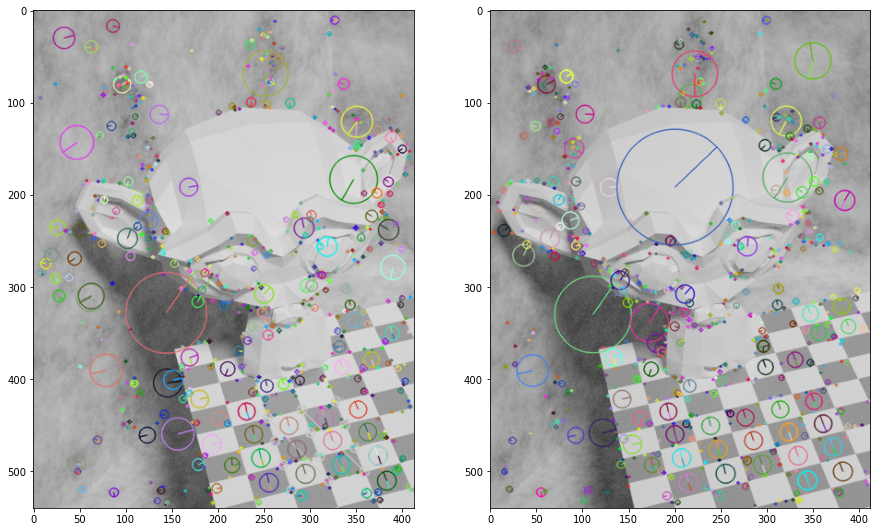

In [10]:
print('SIFT_detector is called: ')
# Initiate SIFT detector
sift = cv2.SIFT_create(contrastThreshold = 0.02)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(imgL, None)
kp2, des2 = sift.detectAndCompute(imgR, None)

key_img = imgL.copy()

plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.drawKeypoints(imgL,kp1,key_img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
plt.subplot(122), plt.imshow(cv2.drawKeypoints(imgR,kp2,key_img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
plt.show()

# Matching, F-matrix, E-matrix

In [11]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
########### (https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

########### manual matches
# pts1 = np.concatenate((pts1,[[162,382],[338,242],[277,515],[97,419],[124,143],[164,220],[40,240],[257,200],[316,371],[403,358]]))
# pts2 = np.concatenate((pts2,[[132,382],[313,242],[244,515],[64,420],[90,143],[132,221],[4,240],[228,200],[288,371],[376,358]]))
###########

# F, mask = cv2.findFundamentalMat(pts1, pts2, method=cv2.RANSAC)
F, mask = cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_7POINT)
print('Fundamental Matrix')
print(F)
# (https://stackoverflow.com/questions/59014376/what-do-i-do-with-the-fundamental-matrix)

# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Essential from Fundamental
# (https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga0c86f6478f36d5be6e450751bbf4fec0)
#E, mask2 = cv2.findEssentialMat(pts1, pts2, cameraMatrix=K, method=cv2.RANSAC)
E, mask2 = cv2.findEssentialMat(pts1, pts2, cameraMatrix=K, method=cv2.FM_7POINT)
print('Essential Matrix')
print(E)

Fundamental Matrix
[[ 1.16078733e-20 -1.01568891e-20  3.29843927e-17]
 [ 6.84683152e-20  2.17647625e-21 -2.38829793e-02]
 [-5.08610693e-17  2.38829793e-02  4.44089210e-15]]
Essential Matrix
[[ 0.00000000e+00  4.91179442e-15  2.53889970e-16]
 [-4.68719945e-15 -3.90599954e-17 -7.07106781e-01]
 [-1.75769979e-16  7.07106781e-01  3.58558551e-18]]


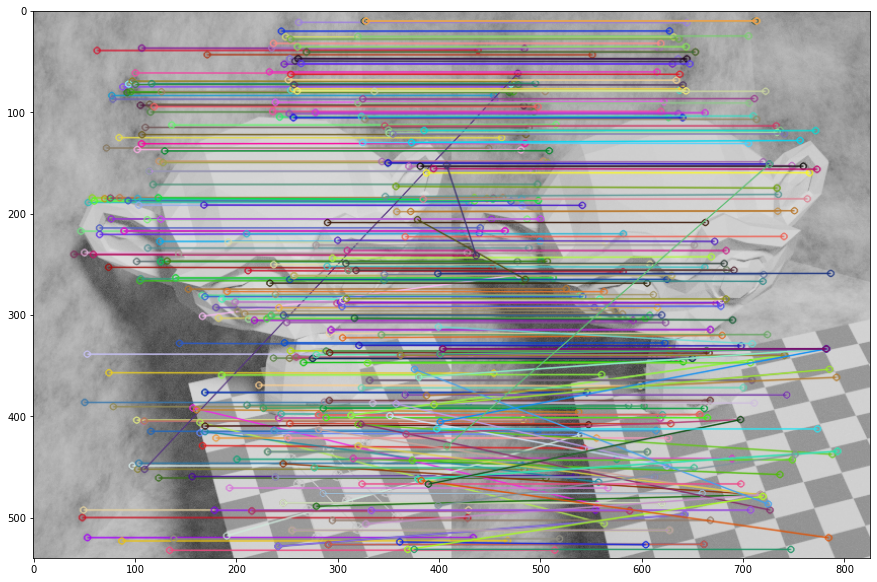

(<matplotlib.image.AxesImage at 0x1272d8c40>, None)

In [12]:
# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(imgL, kp1, imgR, kp2, good, flags=2, outImg=None)

point = kp1[1].pt
for x in kp1:
     if (x.pt[0] < point[0]):
        point = x.pt
plt.figure(figsize=(15,15))
plt.imshow(img3), plt.show()

In [13]:
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1] ])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

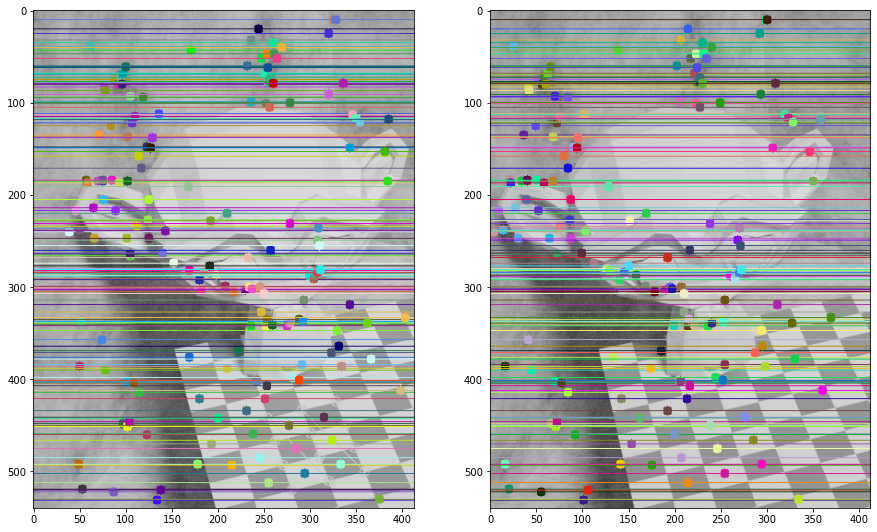

In [14]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(imgL, imgR, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(imgR, imgL, lines2, pts2, pts1)


plt.figure(figsize=(15,14))
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

# Mirror Detection

SIFT_detector has ended: 


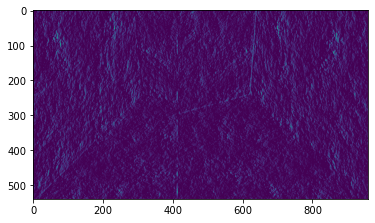

In [15]:
print('SIFT_detector has ended: ')
# Was thinking with edge detection for the mirror corner. But optical flow is probably a better solution.
img = cv2.imread('blender_capture.png')
img = cv2.cvtColor(img[:, :, :], cv2.COLOR_BGR2GRAY)
height, width = img.shape


dst = cv2.Sobel(img, ddepth=cv2.CV_8U, dx=1, dy=0)
dst = cv2.convertScaleAbs(dst)

plt.imshow(dst)
plt.show()

# Camera Calibration

# Image Rectification

In [16]:
info,HL,HR = cv2.stereoRectifyUncalibrated(pts1,pts2,F,imgL.shape)
rectL = cv2.warpPerspective(imgL,HL,(imgL.shape[1], imgL.shape[0]))
rectR = cv2.warpPerspective(imgR,HR,(imgR.shape[1], imgR.shape[0]))

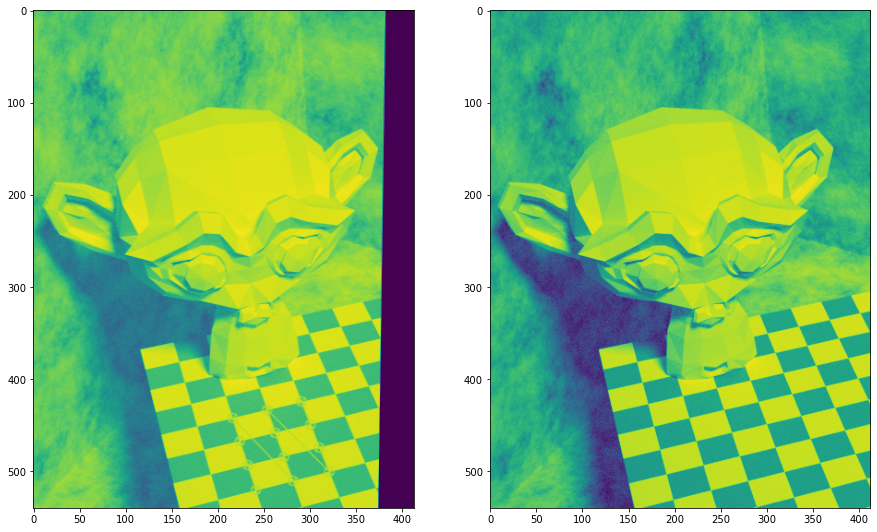

In [17]:
plt.figure(figsize=(15,14))
plt.subplot(121), plt.imshow(rectL)
plt.subplot(122), plt.imshow(rectR)
plt.show()

In [18]:
def computeSVD():
    SD,U,VT = cv2.SVDecomp(E)
    S=np.identity(3)*SD
    return (U,S,VT)

In [19]:
def getRotTrans():
    # singular values decomposition
    U,S,VT = computeSVD()
    W = np.array([
        [0,-1,0],
        [1,0,0],
        [0,0,1]
    ])
    # rotation matrix
    R = np.matmul(np.matmul(U,W.T),VT)
    # get translation in cross matrix, then vector
    tx = np.matmul(U,np.matmul(W,np.matmul(S,U.T)))
    mask = [[2,1],[0,2],[1,0]]
    t = tx[[2,0,1],[1,2,0]].reshape(-1,1)
    # print
    print(np.round(R,decimals=2),np.round(t,decimals=2))
    return (R,t)

In [20]:
b = np.linalg.norm(getRotTrans()[1])

[[-1. -0.  0.]
 [-0.  1. -0.]
 [ 0. -0.  1.]] [[ 0.71]
 [ 0.  ]
 [-0.  ]]


# Disparity Computation 

In [21]:
stereo = cv2.StereoSGBM_create(minDisparity = -10,numDisparities=50, blockSize=18, speckleRange=50, speckleWindowSize=30, uniquenessRatio=9)
#stereo = cv2.StereoBM_create(48,19)
disparity = stereo.compute(rectL,rectR)
#disparity = stereo.compute(rectL,rectR)
print('disparity.shape = ' + str(disparity.shape))

#cv2.namedWindow('disparity map', cv2.WINDOW_NORMAL)
#cv2.setWindowProperty('disparity map', cv2.WINDOW_FULLSCREEN, 1)
#cv2.imshow('disparity map', disparity / disparity.max())

#cv2.waitKey(2 * 60 * 1000) & 0xFF # continue after keypress or after 2min = 2 * 60 * 1000ms
cv2.destroyAllWindows() # close all windows

disparity.shape = (540, 413)


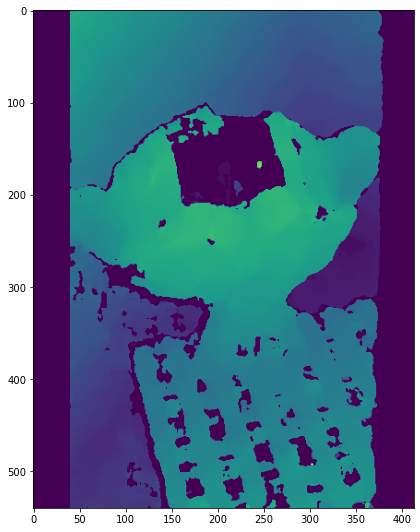

In [22]:
plt.figure(figsize=(15,14))
plt.subplot(121), plt.imshow(disparity)
# plt.subplot(122), plt.imshow(rectR)
plt.show()

In [23]:
f = K[0,0]
Z = f*b/disparity

<ipython-input-23-b8bdcf1cddef>:2: RuntimeWarning: divide by zero encountered in true_divide
  Z = f*b/disparity
